In [1]:
import pickle
import pandas as pd
import numpy as np

#from tfspn.SPN import SPN
from pprint import PrettyPrinter
from IPython.display import Image
from IPython.display import display, Markdown
from importlib import reload

import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

from src.util.text_util import printmd
import src.ba_functions as f
import src.dn_plot as p
import src.dn_text_generation as descr
import src.util.data_util as util
from src.util.spn_util import get_categoricals

from src.util.CSVUtil import learn_piecewise_from_file

init_notebook_mode(connected=True)
# pp = PrettyPrinter()

In [2]:
# path to the dataset you want to use for training
dataset = '../example_data/titanic.csv'

# the minimum number of datapoints that are included in a child of a 
# sum node
min_instances = 50

# the parameter which governs how strict the independence test will be
# 1 results in all features being evaluated as independent, 0 will 
# result in no features being acccepted as truly independent
independence_threshold = 0.3


spn, dictionary = learn_piecewise_from_file(
    data_file=dataset, 
    header=0, 
    min_instances=min_instances, 
    independence_threshold=independence_threshold, )
df = pd.read_csv(dataset)
context = dictionary['context']
categoricals = get_categoricals(spn, context)

In [3]:
descr.explanation_vector_threshold = 0
descr.explanation_vector_classes = None
descr.explanation_vectors_show = 'all'

numerical_data, categorical_data = util.get_categorical_data(spn, df, dictionary)

for i in categorical_data.keys():
    print(context.feature_names[i])

Survived
Gender
Embarked


Survived
[ 0.00000000e+00 -3.45829111e-01  2.41510728e-03  1.13594743e-04
  1.47734593e-01  2.23328287e-01 -4.36815396e-03  1.27800773e-03]
[0.         1.14285714 2.28571429 3.42857143 4.57142857 5.71428571
 6.85714286 8.        ]


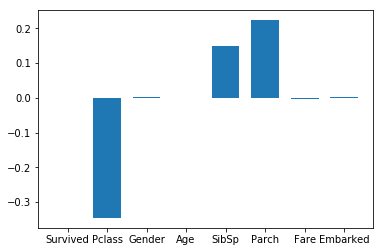

Gender
[ 0.00092799 -0.34436227  0.          0.00259035  0.14862963  0.22192472
 -0.00438849  0.00135924]
[0.         1.14285714 2.28571429 3.42857143 4.57142857 5.71428571
 6.85714286 8.        ]


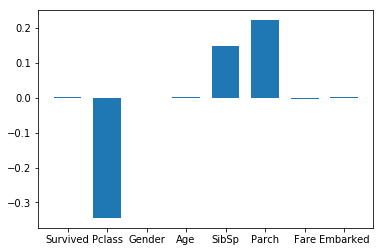

Embarked
[ 4.38396437e-01 -3.95709978e-03  4.70203355e-01 -2.40307607e-06
 -2.19059649e-03  7.39397963e-04  1.91521931e-07  0.00000000e+00]
[0.         1.14285714 2.28571429 3.42857143 4.57142857 5.71428571
 6.85714286 8.        ]


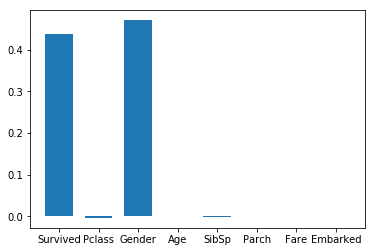

In [4]:
from src.util.spn_util import fast_conditional_gradient
import matplotlib.pyplot as plt

for i in categorical_data.keys():
    print(context.feature_names[i])
    target_data = np.full((1,8), np.nan)
    target_data[:, i] = 0.0
    gradient = fast_conditional_gradient(spn, target_data, numerical_data)
    print(np.mean(np.divide(gradient, np.linalg.norm(gradient, axis=1)[:,None]), axis=0))
    print(np.linspace(0,8,8))
    plt.bar(np.linspace(0,8,8), np.mean(np.divide(gradient, np.linalg.norm(gradient, axis=1)[:,None]), axis=0), tick_label=context.feature_names)
    plt.show()

In [13]:
from spn.structure.StatisticalTypes import MetaType

l = list(range(8))
inserted = []
all_bins = []
for i, (domain, datatype) in enumerate(zip(context.get_domains_by_scope(l), context.get_meta_types_by_scope(l))):
    print(context.feature_names[i])
    if datatype == MetaType.DISCRETE:
        bins = domain
    else:
        bins = (np.linspace(domain[0], domain[-1], 5, endpoint=True))
    all_bins.append(bins)
    inserted.append(np.searchsorted(bins, numerical_data[:, i]))
    # plt.hist(inserted[-1])
    # plt.show()
categorized = np.array(inserted).T

all_feature_influences = []
for cat in categoricals:
    cat_influences = []
    for _class in context.get_domains_by_scope([cat])[0]:
        class_influences = []
        target_data = np.full((1,8), np.nan)
        target_data[:, cat] = _class
        gradient = fast_conditional_gradient(spn, target_data, numerical_data)
        gradient /= np.linalg.norm(gradient, axis=1)[:,None]
        print(gradient)
        for j in range(categorized.shape[1]):
            feature_influences = []
            num_of_bins = len(context.get_domains_by_scope([j])[0]) if context.get_meta_types_by_scope([j])[0] == MetaType.DISCRETE else 5
            for k in range(num_of_bins):
                value_influences = []
                value = np.mean(gradient[np.where(categorized[:,j:j+1] == k)])
                print("For {} class {} and feature {} value {}: {}".format(cat, _class, j, k, value))
                feature_influences.append(value)
            class_influences.append(feature_influences)
        cat_influences.append(class_influences)
    all_feature_influences.append(cat_influences)

Survived
Pclass
Gender
Age
SibSp
Parch
Fare
Embarked
[[ 0.00000000e+00 -1.00000000e+00  1.38173157e-10 ...  6.00788345e-06
   5.21191625e-09  4.66761155e-11]
 [ 0.00000000e+00 -1.00000000e+00 -6.62908794e-10 ...  2.74533448e-08
  -2.94770246e-09  4.31532977e-10]
 [ 0.00000000e+00 -9.99999999e-01  2.58485894e-09 ...  1.62879201e-05
   1.22958166e-08  4.28982313e-10]
 ...
 [ 0.00000000e+00 -1.00000000e+00  7.68854921e-09 ...  3.03303871e-06
  -7.83810354e-07  5.21258794e-11]
 [ 0.00000000e+00  7.56798745e-01  1.80229644e-01 ... -6.07745107e-01
  -1.48037614e-01  2.03464657e-03]
 [ 0.00000000e+00 -9.99999997e-01  3.44967624e-10 ...  6.63332534e-05
  -1.17099709e-08 -1.77476739e-11]]
<built-in function where>
For 0 class 0.0 and feature 0 value 0: 0.0
<built-in function where>
For 0 class 0.0 and feature 0 value 1: 0.0
<built-in function where>
For 0 class 0.0 and feature 1 value 0: 0.0
<built-in function where>
For 0 class 0.0 and feature 1 value 1: nan
<built-in function where>
For 0 cla

[[ 7.01693226e-10 -1.00000000e+00  0.00000000e+00 ...  6.01021844e-06
   5.21365077e-09  1.61553032e-10]
 [ 8.22740365e-09 -1.00000000e+00  0.00000000e+00 ...  2.74445368e-08
  -2.95225037e-09  4.05696179e-10]
 [ 3.37305365e-09 -9.99999999e-01  0.00000000e+00 ...  1.62613765e-05
   1.22317458e-08  4.86577873e-10]
 ...
 [ 4.19933161e-09 -1.00000000e+00  0.00000000e+00 ...  2.79817108e-06
  -7.28692025e-07  6.63333262e-11]
 [-3.56136750e-02  7.69113022e-01  0.00000000e+00 ... -6.17279840e-01
  -1.50155456e-01  1.95879644e-03]
 [-1.74782100e-09 -9.99999997e-01  0.00000000e+00 ...  6.63426902e-05
  -1.17115413e-08 -6.91026502e-12]]
<built-in function where>
For 2 class 1.0 and feature 0 value 0: 0.0014689440606834732
<built-in function where>
For 2 class 1.0 and feature 0 value 1: 0.00012095364661331609
<built-in function where>
For 2 class 1.0 and feature 1 value 0: 0.0016930080617882572
<built-in function where>
For 2 class 1.0 and feature 1 value 1: nan
<built-in function where>
For 2 c

[[ 7.27745055e-01 -4.75355095e-02  6.84198444e-01 ...  2.85770985e-07
   2.47884759e-10  0.00000000e+00]
 [ 9.13701574e-01 -2.52006832e-03  4.06378004e-01 ...  6.91243775e-11
  -7.44287752e-12  0.00000000e+00]
 [ 9.13704452e-01 -2.29518679e-04  4.06379284e-01 ...  3.42029441e-09
   3.02346189e-12  0.00000000e+00]
 ...
 [ 8.04600316e-02 -2.56580884e-04  9.96757803e-01 ...  1.02657563e-09
  -3.08209121e-10  0.00000000e+00]
 [ 8.04088496e-02  7.88521524e-04  9.96761440e-01 ... -6.32332322e-04
  -1.53816721e-04  0.00000000e+00]
 [ 8.04484099e-02 -1.69978127e-02  9.96613831e-01 ...  1.12794337e-06
  -1.99008581e-10  0.00000000e+00]]
<built-in function where>
For 7 class 2.0 and feature 0 value 0: 0.8848489069716092
<built-in function where>
For 7 class 2.0 and feature 0 value 1: -0.2188808114340991
<built-in function where>
For 7 class 2.0 and feature 1 value 0: 0.16522479770659648
<built-in function where>
For 7 class 2.0 and feature 1 value 1: nan
<built-in function where>
For 7 class 2.0

In [10]:
for cat in categoricals:
    for _class in context.get_domains_by_scope([cat])[0]:
        influence = all_feature_influences[int(cat)][int(_class)]
        print(np.array(influence))

[[0.0, 0.0], [0.0, nan, 0.0, nan, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.0, 0.0], [0.0, nan, 0.0, nan, 0.0], [0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
[[0.8848489069716092, -0.2188808114340991], [0.16522479770659648, nan, 0.4248792216924049, nan, 0.5865712527665972], [0.24039407181786587, 0.5516030866713345], [-0.848928352153385, 0.3645578679587776, 0.4576006239987212, 0.45610321629212935, 0.6664780675014879], [0.4759789616928392, 0.295614691872315, 0.45046397682430483, 0.5737280956309095, 0.724361071660349], [0.48831876952347003, 0.28809115695510584, 0.2714768327447473, 0.8211365626819176, 0.6514065290174895], [0.6618997840185324, 0.45035944946878254, 0.19127682698069384, 0.35820830054577485, -0.5391322321776836], [0.22859965360876308, 0.6093652878864508, 0.47898570366964255]]
[[0.8848

IndexError: list index out of range